In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
dataset=MNIST(root='data/',download=True,transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



5


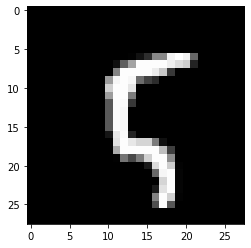

In [4]:
image,label=dataset[100]
plt.imshow(image.permute(1,2,0),cmap='gray')
print(label)

In [5]:
val_size=10000
train_size=len(dataset)-val_size
train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds)

50000

In [6]:
batch_size=100
train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([100, 1, 28, 28])


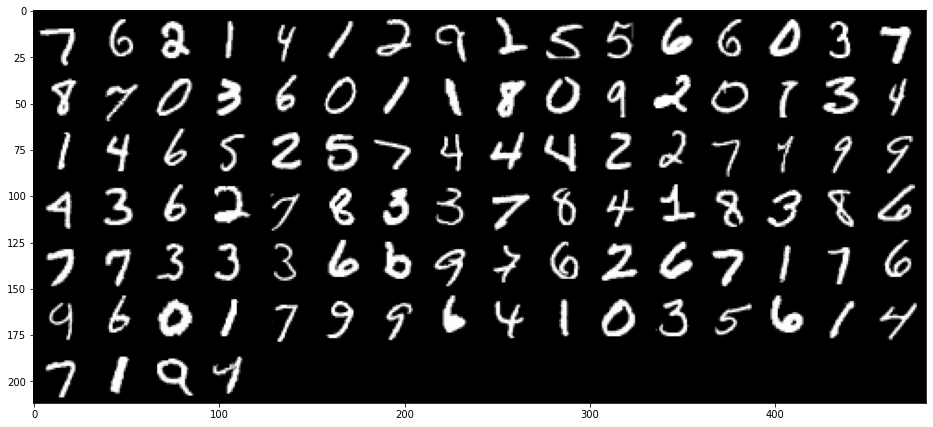

In [7]:
for images, _ in train_loader:
    print(images.shape)
    plt.figure(figsize=(16,8))
    plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

In [8]:
for images, labels in train_loader:
    print(images.shape)
    inputs=images.reshape(-1,784)
    print(inputs.shape)
    break

torch.Size([100, 1, 28, 28])
torch.Size([100, 784])


In [9]:
input_size=inputs.shape[-1]
print(input_size)

784


In [10]:
hidden_size=32

In [11]:
layer1=nn.Linear(input_size,hidden_size)

In [12]:
layer1_output=layer1(inputs)

In [13]:
layer1_output.shape

torch.Size([100, 32])

In [14]:
layer1_output_direct=inputs@layer1.weight.t()+layer1.bias
print(layer1_output_direct.shape)

torch.Size([100, 32])


In [15]:
relu_outputs=F.relu(layer1_output)

In [16]:
print(relu_outputs[0])

tensor([0.4224, 0.1457, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2920, 0.0000,
        0.1579, 0.0437, 0.1854, 0.1186, 0.0933, 0.0774, 0.2120, 0.0000, 0.2752,
        0.1343, 0.0060, 0.0000, 0.1409, 0.0000, 0.1790, 0.0575, 0.0000, 0.0000,
        0.1183, 0.0000, 0.1067, 0.1272, 0.0000], grad_fn=<SelectBackward0>)


In [17]:
output_size=10
Layer2=nn.Linear(hidden_size,output_size)

In [18]:
layer2_outputs=Layer2(relu_outputs)

In [19]:
layer2_outputs.shape

torch.Size([100, 10])

In [20]:
F.cross_entropy(layer2_outputs,labels)

tensor(2.3205, grad_fn=<NllLossBackward0>)

In [21]:
outputs=relu_outputs@Layer2.weight.t()+Layer2.bias

In [22]:
#creating a single layer as a replacement of two linear layers
combined_layer= nn.Linear(input_size,output_size)
combined_layer.weight.data = Layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ Layer2.weight.t() + Layer2.bias

In [23]:
outputs=inputs@combined_layer.weight.t()+ combined_layer.bias

In [24]:
outputs

tensor([[ 1.5079e-02,  9.3406e-02,  2.8099e-02,  3.3619e-02,  1.9018e-01,
          1.9386e-01,  5.4591e-02, -9.5617e-03, -4.6849e-02,  1.8747e-01],
        [-1.8025e-01, -1.0619e-02,  7.6781e-02, -3.2201e-02, -3.1946e-03,
          1.7410e-01,  8.2394e-02,  2.0493e-01,  7.5999e-02,  2.4722e-01],
        [-6.8997e-02, -1.5493e-01,  2.9583e-01, -1.3969e-01,  9.8744e-03,
          2.3599e-01, -1.7461e-01,  1.8452e-01,  3.1662e-02,  2.1496e-01],
        [ 4.6344e-02,  5.0023e-02,  2.7980e-02, -6.0877e-02,  9.1614e-02,
          2.0567e-01, -8.1915e-02,  2.9741e-02, -1.1711e-01,  2.6179e-01],
        [-8.1124e-02, -5.6227e-02,  5.2014e-02, -8.7013e-02,  1.1901e-01,
          2.6162e-01,  7.7161e-02, -7.5011e-02,  5.0504e-02,  1.7758e-01],
        [ 2.8781e-03,  1.1473e-01,  1.9691e-01,  9.4527e-03,  1.1082e-01,
          2.1493e-01, -3.6818e-02,  4.4253e-02, -2.0590e-01,  2.8452e-01],
        [-5.4194e-02, -6.4664e-02,  1.0410e-02, -7.0938e-02,  1.2819e-01,
          1.8138e-01, -3.9947e-0

In [62]:
class Model(nn.Module) :
    def __init__(self,input_size,hidden_size1,out_size) :
        super().__init__()
        self.Linear1=nn.Linear(input_size,hidden_size1)
        self.Linear2=nn.Linear(hidden_size1,out_size)
    def forward(self ,xb) :
        xb=xb.view(xb.size(0),-1)
        out=self.Linear1(xb)
        out=F.relu(out)
        out=self.Linear2(out)
        return out
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    

In [26]:
for xb,yb in train_loader :
    print(xb.shape)
    break  

torch.Size([100, 1, 28, 28])


In [27]:
input_size=784
out=10
model=Model(input_size,hidden_size1=32,
            out_size=out)

In [28]:
for t in model.parameters() :
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [29]:
for images,labels in train_loader :
    print(images.shape)
    output=model(images)
    loss=F.cross_entropy(output,labels)
    print(loss)
    break
print(outputs.shape)
    

torch.Size([100, 1, 28, 28])
tensor(2.3135, grad_fn=<NllLossBackward0>)
torch.Size([100, 10])


In [30]:
print(F.softmax(outputs)[:1].data)

tensor([[0.0939, 0.1016, 0.0952, 0.0957, 0.1119, 0.1123, 0.0977, 0.0917, 0.0883,
         0.1116]])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [31]:
torch.cuda.is_available()

True

In [32]:
def get_default_device() :
    if torch.cuda.is_available() :
        return torch.device('cuda')
    else :
        return torch.device('cpu')
    
        

In [33]:
device=get_default_device()
device

device(type='cuda')

In [34]:
def to_device(data,device) :
    return data.to(device,non_blocking=True)

In [35]:
for images,labels in train_loader :
    print(images.shape)
    images=to_device(images,device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cuda:0


In [58]:
class DeviceDataLoader() :
    def __init__(self,dl,device) :
        self.dl=dl
        self.device=device
    def __iter__(self) :
        for b in self.dl :
            yield to_device(b,self.device)
    def __len__(self) :
        return len(self.dl)

In [59]:
train_loader=DeviceDataLoader(train_loader,device)
val_loader=DeviceDataLoader(val_loader,device)
for xb,yb in val_loader :
    print(xb.shape)
    print(yb.shape)
    break

torch.Size([200, 1, 28, 28])
torch.Size([200])


In [67]:
def evaluate(model,val_loader) :
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD) :
    history=[]
    optimizer=opt_func(model.parameters(),lr)
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [64]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [61]:
model=Model(input_size,hidden_size1=32,out_size=out)
to_device(model,device)

Model(
  (Linear1): Linear(in_features=784, out_features=32, bias=True)
  (Linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [68]:
history=[evaluate(model,val_loader)]

In [69]:
history

[{'val_loss': 2.3094029426574707, 'val_acc': 0.10349998623132706}]

In [70]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2101, val_acc: 0.9352
Epoch [1], val_loss: 0.1594, val_acc: 0.9528
Epoch [2], val_loss: 0.1512, val_acc: 0.9574
Epoch [3], val_loss: 0.1361, val_acc: 0.9618
Epoch [4], val_loss: 0.1425, val_acc: 0.9574


In [71]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1130, val_acc: 0.9684
Epoch [1], val_loss: 0.1139, val_acc: 0.9696
Epoch [2], val_loss: 0.1129, val_acc: 0.9688
Epoch [3], val_loss: 0.1126, val_acc: 0.9682
Epoch [4], val_loss: 0.1126, val_acc: 0.9690


Text(0, 0.5, 'loss')

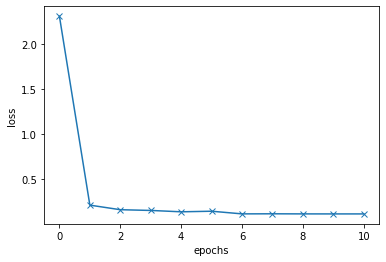

In [72]:
losses=[x['val_loss'] for x in history]
plt.plot(losses ,'-x')
plt.xlabel('epochs')
plt.ylabel('loss')

Text(0, 0.5, 'Accuracy')

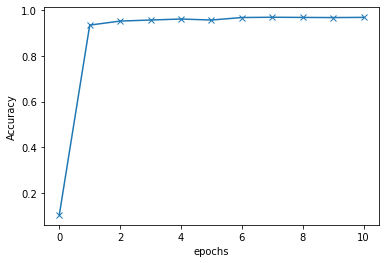

In [73]:
Accuracy=[x['val_acc'] for x in history]
plt.plot(Accuracy ,'-x')
plt.xlabel('epochs')
plt.ylabel('Accuracy')